# Rozwiązanie zadania testowego

## Opis problemu

Zgodnie z opisem zawartym w wysłanym .xlsx:

1. Na podstawie załączonych danych (DANE) przeprowadź regresję logistyczną i stworz model logit/probit
  1. Stwórz zmienną zależną (0,1) opisującą dobrego klienta (0) oraz złego (1) na podstawie dni opóźnienia (Day past due) (Próg kwalifikacji klienta jako złego na podstawie dni opóźnienia zaproponuj samemu na podstawie załączonych danych (przyjmuje się, że minimalny default rate do modelowania = 10%)
  1. Przedstaw proces obróbki danych (tworzenia zmiennych objaśniających) oraz doboru zmiennych do modelu jak i poszczególne etapy (proces dochodzenia do ostatecznej formy funkcyjnej modelu) wyboru ostatecznej formy funkcyjnej modelu
    1. Dokonaj kategoryzacji zmiennych (dowolną metodą, może być za pomocą WOE)		
    1. Zaprezentuj wyniki estymacji dla poszczególnych form funkcyjnych modelu (wyniki estymacji parametrów dla poszczególnych zmiennych, statystyki t-studenta, p-value, bład standardowy)		
    1. Zaprezentuj macierze wariancji-kowariancji, macierze perasona dla poszczególnych etapów doboru  zmiennych (dla kolejnych funkcji modelu)
    1. Możesz posłyżyć się jedną z metod doboru zmiennych zawartych w pakietach statystycznych programu R (np. stepAIC lub inne podobne) 
    1. Policz statystki Gini i KS dla poszczególnych etapów wyboru ostatecznej formy 	  	          funkcyjnej modelu.

1. Zaprezentuj ostateczną formę funkcyjną modelu oraz wyniki estymacji, krzywą ROC oraz wskaźnik GINI i KS, wyodrębnij losowo z danych próbę testującą (30% calej próby użytej do budowy modelu) i przetstuj na tej próbie stabilność modelu. 

1. Stwórz i zaprezentuj kartę scoringową dla ostatecznego modelu za pomoca dowolnej f-cji kalibrującej.

**Uwaga!!!**

Możesz użyć dowolnego programu do obróbki danych i modelowania, preferowany R Cran. Od Twojej kreatywności zależy jakie zmienne objaśniające stworzysz. Ilość etapów doboru zmiennych do wyprowadzenia ostatecznej funkcji modelu jest dowolna, zależna od wykonanej przez Ciebie analizy danych. Przede wszystkim interesujący jest proces dojścia do ostatecznej funkcji modelu oraz metody radzenia sobie z problemami statystycznymi wynikającymi z danych a nie sama finalna forma funkcyjna oraz wyniki.

## Importowanie bibliotek

In [1]:
# ogólne
import pdb
import warnings
from collections import defaultdict

# statysyczne
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm

# wizualizacja
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('seaborn')

Aby zapewnić odtwarzalność wyników, ustalimy wspólne ziarno generatora liczb pseudolosowych:

In [2]:
seed = 5
np.random.seed(seed)

## Import danych

Importujemy dane do zadania przy pomocy popularnego pakietu Pandas:

In [3]:
df = pd.read_excel('ZADANIE_MODEL.xlsx', index_col=0); df.head()

,term /period,principal_approved,overpayment_received,dpd (day past due),product_type,created_at,maturity_date,principal_paid,commission_outstanding,commission_due,...,total_outstanding,total_due,total_past_due,total_charged,total_paid,extension_times,extension_term,number of transactions,cash_in,cash_out
loan_id,,,,,,,,,,,,,,,,,,,,,
1,30,500.0,0.0,0,PAYDAY,2018-12-21 12:15:33.944587,2019-01-20,500.0,0.0,0.0,...,595.0,595.0,0.0,595.0,0.0,0,0,6,0.0,500.0
2,14,500.0,0.0,0,PAYDAY,2019-01-06 17:23:08.631333,2019-01-20,500.0,0.0,0.0,...,595.0,595.0,0.0,595.0,0.0,0,0,5,0.0,500.0
3,14,500.0,0.0,-13,PAYDAY,2019-01-20 19:21:19.194970,2019-02-03,0.0,75.0,75.0,...,650.0,650.0,650.0,650.0,0.0,0,0,6,0.0,500.0
4,61,500.0,0.0,3,INSTALLMENT,2018-12-18 15:05:04.234255,2019-02-17,0.0,96.0,96.0,...,0.0,0.0,0.0,545.0,545.0,0,0,3,545.0,500.0
5,30,500.0,0.0,-28,PAYDAY,2019-01-18 05:18:58.283775,2019-02-17,500.0,0.0,0.0,...,595.0,595.0,0.0,595.0,0.0,0,0,7,0.0,500.0


Sprawdzamy podstawowe informacje o tabeli:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 45 columns):
term /period                             500 non-null int64
principal_approved                       500 non-null float64
overpayment_received                     500 non-null float64
dpd (day past due)                       500 non-null int64
product_type                             500 non-null object
created_at                               500 non-null object
maturity_date                            500 non-null datetime64[ns]
principal_paid                           500 non-null float64
commission_outstanding                   500 non-null float64
commission_due                           500 non-null float64
commission_past_due                      500 non-null float64
commission_charged                       500 non-null float64
commission_paid                          500 non-null float64
penalty_outstanding                      500 non-null float64
penalty_due               

W naszym zestawie jest 500 obserwacji i aż 45 cech. Dla sprawniejszego poruszania się w danych uprościmy nieco nazewnictwo kolumn:

In [5]:
df.columns = ['term/period', 'principal_approved', 'overpayment_received',
       'dpd', 'product_type', 'created_at', 'maturity_date',
       'principal_paid', 'commission_outstanding', 'commission_due',
       'commission_past_due', 'commission_charged', 'commission_paid',
       'penalty_outstanding', 'penalty_due', 'penalty_past_due',
       'penalty_charged', 'penalty_paid', 'fee', 'fee_paid', 'status',
       'phone_verified_at', 'loan_number', 'requested_principal',
       'n_req_ext_bur', 'principal_outstanding',
       'principal_due', 'principal_past_due', 'principal_charged',
       'principal_paid.1', 'penalty_outstanding.1', 'penalty_due.1',
       'penalty_past_due.1', 'penalty_charged.1', 'penalty_paid.1',
       'total_outstanding', 'total_due', 'total_past_due', 'total_charged',
       'total_paid', 'extension_times', 'extension_term',
       'n_transactions', 'cash_in', 'cash_out']

## Analiza danych (EDA)

**Wstępna analiza**

Wyświetlimy teraz podstawowe statystyki cech zawartych w tabeli danych:

In [6]:
for key, val in dict(df.describe(include='all')).items(): print(key, '\n', val, '\n\n')

term/period 
 count     500.000000
unique           NaN
top              NaN
freq             NaN
first            NaN
last             NaN
mean       33.156000
std        14.096563
min         1.000000
25%        30.000000
50%        30.000000
75%        30.000000
max        61.000000
Name: term/period, dtype: float64 


principal_approved 
 count      500.000000
unique            NaN
top               NaN
freq              NaN
first             NaN
last              NaN
mean       503.000000
std         49.959904
min        500.000000
25%        500.000000
50%        500.000000
75%        500.000000
max       1500.000000
Name: principal_approved, dtype: float64 


overpayment_received 
 count     500.0
unique      NaN
top         NaN
freq        NaN
first       NaN
last        NaN
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: overpayment_received, dtype: float64 


dpd 
 count     500.000000
unique           NaN


Na tym etapie warto też potwierdzić liczbę brakujących wartości:

In [7]:
df.isna().sum()

term/period                 0
principal_approved          0
overpayment_received        0
dpd                         0
product_type                0
created_at                  0
maturity_date               0
principal_paid              0
commission_outstanding      0
commission_due              0
commission_past_due         0
commission_charged          0
commission_paid             0
penalty_outstanding         0
penalty_due                 0
penalty_past_due            0
penalty_charged             0
penalty_paid                0
fee                         0
fee_paid                    0
status                      0
phone_verified_at         372
loan_number                 0
requested_principal         0
n_req_ext_bur               0
principal_outstanding       0
principal_due               0
principal_past_due          0
principal_charged           0
principal_paid.1            0
penalty_outstanding.1       0
penalty_due.1               0
penalty_past_due.1          0
penalty_ch

Braki mamy jak widać jedynie w zmiennej `phone_verified_at` - przyjrzymy się temu bliżej w toku analizy poszczególnych zmiennych.

W pierwszej kolejności przejrzymy zmienne oznaczone jako typ danych `object`, a więc potencjalnie dane kategoryczne:

In [8]:
df[df.dtypes[df.dtypes == 'object'].index].head()

,product_type,created_at,status,phone_verified_at
loan_id,,,,
1,PAYDAY,2018-12-21 12:15:33.944587,PAID,NaN
2,PAYDAY,2019-01-06 17:23:08.631333,PAID,NaN
3,PAYDAY,2019-01-20 19:21:19.194970,PAID,2018-12-14 15:34:33.905597
4,INSTALLMENT,2018-12-18 15:05:04.234255,PAID,NaN
5,PAYDAY,2019-01-18 05:18:58.283775,PAID,NaN


Kilka z nich to tak naprawdę daty, które prawdopodobnie ze względu na dłuższy format nie zostały automatycznie zaklasyfikowane jako format `datetime` - skorygujemy to więc teraz:

In [9]:
for col in ['created_at', 'maturity_date', 'phone_verified_at']: df[col] = pd.to_datetime(df[col], format='%Y.%m.%d')

Zmienne `product_type` i `status` mają natomiast charakter jakościowy. Sprawdźmy ich kardynalność i częstotliwość obserwacji dla poszczególnych kategorii:

In [10]:
for col in ['product_type', 'status']: print('*'*10, col.upper(), '\n', df[col].value_counts(), '\n')

********** PRODUCT_TYPE 
 PAYDAY         415
INSTALLMENT     85
Name: product_type, dtype: int64 

********** STATUS 
 PAID         486
CANCELLED     14
Name: status, dtype: int64 



Obie zmienne przyjmują jedynie po dwie wartości. Oznacza to, że możemy zaprezentować je w naszych danych jako zmienne binarne:

In [11]:
df['is_installment'] = df['product_type'].apply(lambda x: 1 if x=='INSTALLMENT' else 0)
df['is_cancelled'] = df['status'].apply(lambda x: 1 if x=='CANCELLED' else 0)
df[['is_installment', 'is_cancelled']].describe()

,is_installment,is_cancelled
count,500.000000,500.000000
mean,0.170000,0.028000
std,0.376009,0.165138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Tym samym oryginalne zmienne kategoryczne możemy oznaczyć do wyrzucenia - nie przydadzą nam się bezpośrednio w procesie estymacji modelu:

In [12]:
to_exclude = ['product_type', 'status']

**Określenie zmiennej decyzyjnej**

Zgodnie z założeniem zadania, przyjrzymy się zmiennej `dpd` aby zdefiniować zmienną decyzyjną do modelu. Spójrzmy na rozkład `dpd`:

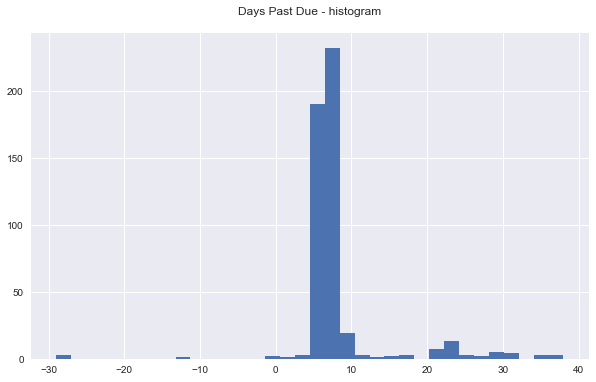

In [13]:
dpd = df['dpd']
plt.figure(figsize=(10,6))
plt.title('Days Past Due - histogram\n')
dpd.hist(bins=len(dpd.unique()))
plt.show()

Wygląda na to, że zdecydowana większość klientów zalega z płatnościami co najmniej kilka dni. Wyświetlmy jeszcze raz szczegółowe statystyki:

In [14]:
dpd.describe()

count    500.000000
mean       8.102000
std        6.633219
min      -29.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       38.000000
Name: dpd, dtype: float64

Widzimy też, że `dpd` przyjmuje negatywne wartości w zestawie. Jeśli nie jest to błąd w danych, możemy podejrzewać, że chodzi tu o przedpłaty. Nie potwierdza tego co prawda zawarta w zestawie cecha `overpayment_received`:

In [15]:
df['overpayment_received'].describe()

count    500.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: overpayment_received, dtype: float64

Przyjmuje ona bowiem dla wszystkich obserwacji w zestawie wartość 0. Oznacza to jednocześnie, że zmienna ta nie nadaje się do użycia w modelu gdyż nie wprowadza żadnej zmienności w danych. Oznaczymy ją zatem również jako zmienną do wykluczenia:

In [16]:
to_exclude.append('overpayment_received')

Możemy natomiast sprawdzić jak się mają wartości ujemne `dpd` do cechy dotyczącej (najprawdopodobniej) kar naliczonych za opóźnienia - `penalty_charged`:

In [17]:
edf = df[['dpd', 'penalty_charged']].copy()
edf['dpd_sign'] = edf['dpd'].apply(lambda x: "DPD poniżej / równe 0" if x <= 0 else "DPD większe niż 0")
edf[['dpd_sign', 'penalty_charged']].groupby('dpd_sign').mean()

,penalty_charged
dpd_sign,
DPD poniżej / równe 0,0.000000
DPD większe niż 0,41.384615


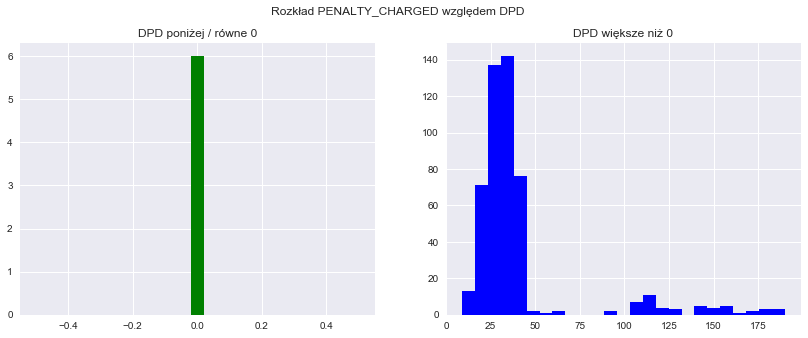

In [18]:
plt.figure(figsize=(14, 5))
plt.suptitle('Rozkład PENALTY_CHARGED względem DPD')
for i in [0,1]:
    plt.subplot2grid((1, 2), (0, i))
    val = edf['dpd_sign'].unique()[i]
    plt.title(val)
    edf['penalty_charged'][edf['dpd_sign'] == val].hist(color=['g', 'b'][i], bins=25)

Dla wartości `dpd` mniejszych lub równych zero nie są naliczone kary, co stanowi pewne potwierdzenie naszej tezy - na ten moment będziemy się więc trzymali tej interpretacji. 

Wracając do statystyk `dpd`: ponad 75% obserwacji znajduje się poniżej średniej wartości - 8.1, natomiast tylko 25% klientów nie przekracza 6 dni w opóźnieniach spłaty. Z jednej strony wydaje się ogólnie niepokojące, że przy pożyczkach na tak krótki termin (sądząc po wartościach przyjmowanych przez zmienną `term/period`) jest tyle opóźnień w spłatach. Z drugiej, czysto biznesowej strony, nie chcemy tworzyć modelu, który będzie dyskryminował większość populacji obecnych klientów. 

Ze względu na opisane cechy rozkładu `dpd`, średnia mogłaby posłużyć jako wartość graniczna przy klasyfikacji na dobrych i złych klientów:

In [19]:
threshold = dpd.mean()
print(f'Dla progowej wartości DPD {threshold:.2f} odsetek dobrych klientów to {(dpd > threshold).sum() / len(dpd) * 100:.2f}%')

Dla progowej wartości DPD 8.10 odsetek dobrych klientów to 13.60%


W takiej sytuacji odsetek dyskryminowanych klientów przekroczy 10% a więc będzie w zgodzie ze standardowymi praktykami przy tworzeniu modeli ryzyka kredytowego.

Zdefiniujemy więc zmienną decyzyjną jako:

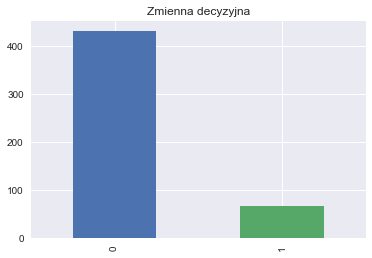

In [20]:
df['class'] = (dpd > threshold).astype('int')
df['class'].value_counts().plot.bar(title='Zmienna decyzyjna')
plt.show()

Ze względu na to, że ze zmiennej `dpd` pozyskaliśmy naszą zmienną decyzyjną, nie będziemy jej używali jako predyktora w modelu. W związku z tym dołączymy ją do grupy zmiennych do wykluczenia:

In [21]:
to_exclude.append('dpd')

**Przegląd zmiennych**

Spojrzymy teraz uważniej na pozostałe zmienne, które rozważamy do naszego modelu:

In [22]:
df.drop(columns=['dpd', 'class'] + to_exclude).columns

Index(['term/period', 'principal_approved', 'created_at', 'maturity_date',
       'principal_paid', 'commission_outstanding', 'commission_due',
       'commission_past_due', 'commission_charged', 'commission_paid',
       'penalty_outstanding', 'penalty_due', 'penalty_past_due',
       'penalty_charged', 'penalty_paid', 'fee', 'fee_paid',
       'phone_verified_at', 'loan_number', 'requested_principal',
       'n_req_ext_bur', 'principal_outstanding', 'principal_due',
       'principal_past_due', 'principal_charged', 'principal_paid.1',
       'penalty_outstanding.1', 'penalty_due.1', 'penalty_past_due.1',
       'penalty_charged.1', 'penalty_paid.1', 'total_outstanding', 'total_due',
       'total_past_due', 'total_charged', 'total_paid', 'extension_times',
       'extension_term', 'n_transactions', 'cash_in', 'cash_out',
       'is_installment', 'is_cancelled'],
      dtype='object')

W pierwszej kolejności pola dat czyli `created_at` oraz `maturity_date`:

In [23]:
df[['created_at', 'maturity_date']].head()

,created_at,maturity_date
loan_id,,
1,2018-12-21 12:15:33.944587,2019-01-20
2,2019-01-06 17:23:08.631333,2019-01-20
3,2019-01-20 19:21:19.194970,2019-02-03
4,2018-12-18 15:05:04.234255,2019-02-17
5,2019-01-18 05:18:58.283775,2019-02-17


W takim formacie nie jesteśmy oczywiście w stanie użyć ich bezpośrednio jako zmiennych w modelu. Moglibyśmy teoretycznie na ich podstawie policzyć czas trwania pożyczki. Wygląda jednak na to, że mamy już taką zmienną - `term/period`:

In [24]:
pd.concat(((df['maturity_date'] - df['created_at']).rename(
    'maturity_date - created_at'), df['term/period']), axis=1).head(15)

,maturity_date - created_at,term/period
loan_id,,
1,29 days 11:44:26.055413,30
2,13 days 06:36:51.368667,14
3,13 days 04:38:40.805030,14
4,60 days 08:54:55.765745,61
5,29 days 18:41:01.716225,30
6,29 days 03:17:40.468445,30
7,29 days 03:08:50.892065,30
8,29 days 11:55:52.176967,30
9,29 days 07:27:21.070800,30


Jak widać, `term/period` jest zaokrągloną w górę wartością różnicy (wyrażonej w dniach) pomiędzy tymi zmiennymi.

Z pola dat można teoretycznie wyciągnąć wiele innych informacji, np. takich które pomogłyby wnioskować o potencjalnym wpływie sezonowości. Nasz zbiór dancyh jest jednak mocno ograniczony czasowo - w większości są to pożyczki z jednego miesiąca (grudzień 2018):

In [25]:
df['created_at'].dt.month.value_counts()

12    495
1       5
Name: created_at, dtype: int64

Na ten moment wykluczymy więc te zmienne z procesu modelowania:

In [26]:
for col in ['created_at', 'maturity_date']: to_exclude.append(col)

Wróćmy teraz do `phone_verified_at` - tak jak widzieliśmy wcześniej, brakuje tu ponad 74% wartości:

In [27]:
df['phone_verified_at'].isna().sum() / len(df)

0.744

Mimo tak wielu brakujących danych może się w teorii okazać, że te wartości które mamy w zestawie ułatwią dyskryminowanie złych klientów. Sprawdzimy więc jaki jest rozkład brakujących i istniejących obserwacji względem zmiennej decyzyjnej aby wstępnie oszacować czy włączanie tej zmiennej do procesu modelowania ma jakikolwiek sens:

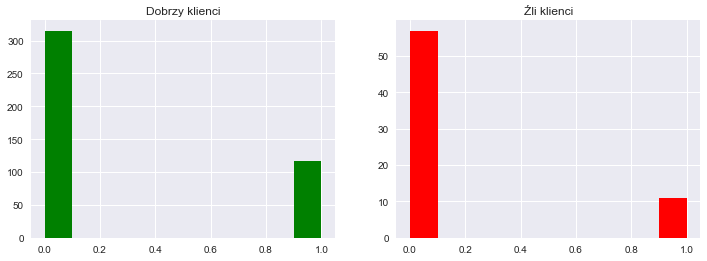

In [28]:
edf = df[['class', 'phone_verified_at']].copy()
edf['has_phone'] = edf['phone_verified_at'].fillna(0).apply(lambda x: 0 if x==0 else 1)
plt.figure(figsize=(12, 4))
for i in [0, 1]:
    plt.subplot2grid((1, 2), (0, i))
    plt.title(["Dobrzy klienci", "Źli klienci"][i])
    edf['has_phone'][edf['class']==i].hist(color=['g', 'r'][i])

Wydaje się, że źli klienci mają relatywnie więcej brakujących wartości zmiennej `phone_verified_at`. Nie jest to jednak silna statystycznie różnica. Tę zmienną przeznaczymy więc również do wyrzucenia z procesu modelowania:

In [29]:
to_exclude.append('phone_verified_at')

Przy wstępnej analizie statystyk poszczególnych cech zaobserwować można było wiele zmiennych, które przyjmowały tę samą wartość dla wszystkich kwartyli. Zawęzimy tę grupę do tych, które mają identyczny kwantyl rzędzo 0.15 i 0.85 - a więc takich, które mogłyby mieć potencjalnie podobny rozkład do zmiennej decyzyjnej - i sprawdzimy ich rozkład względem niej:

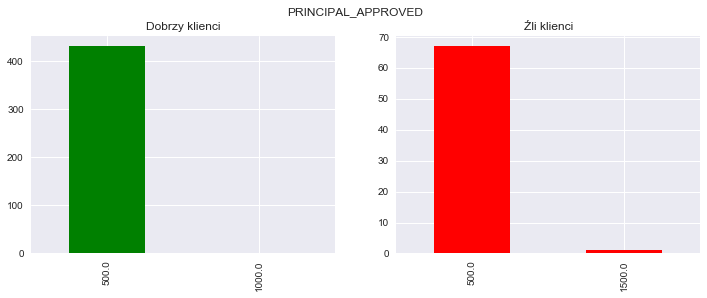

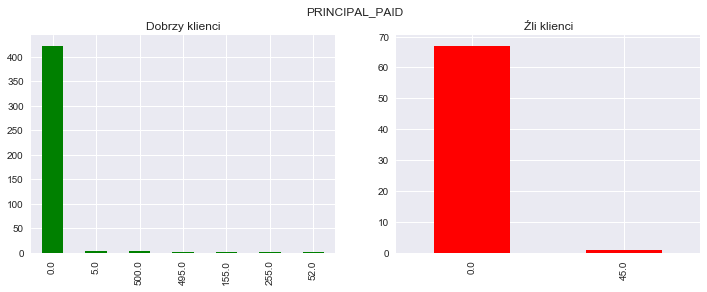

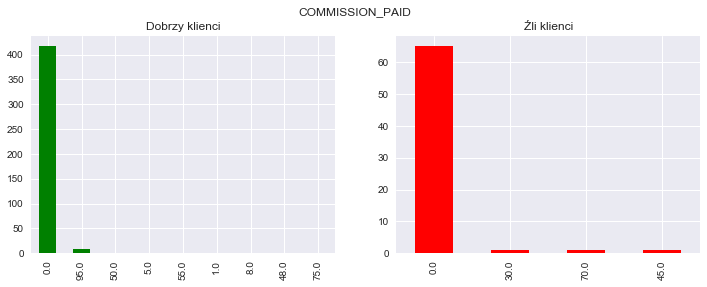

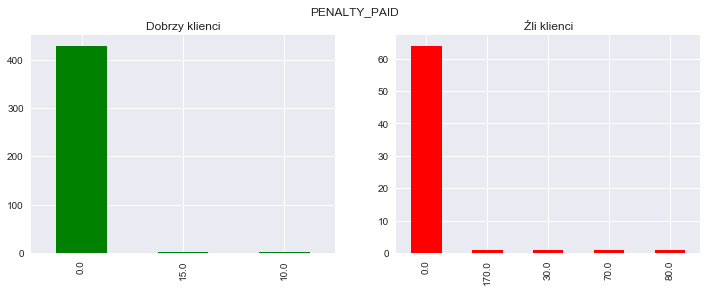

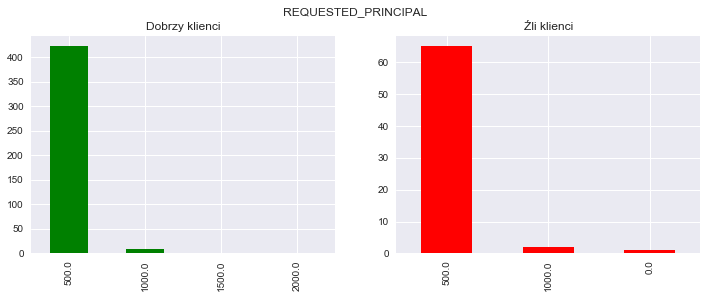

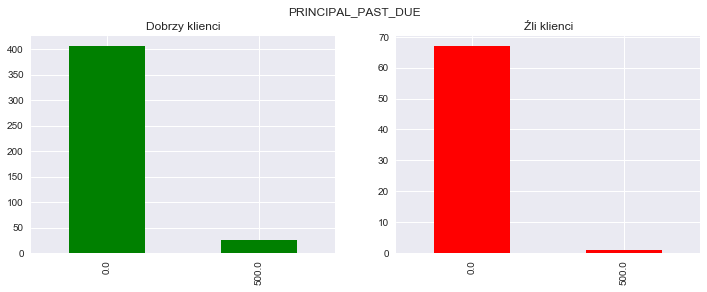

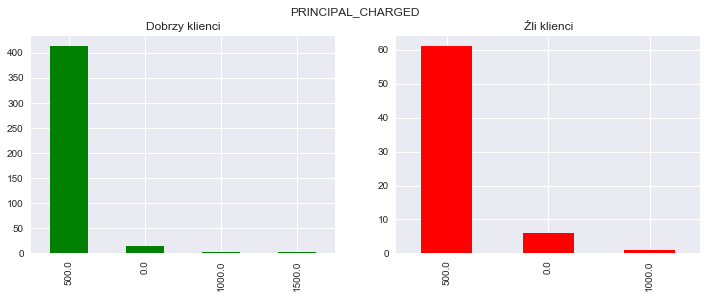

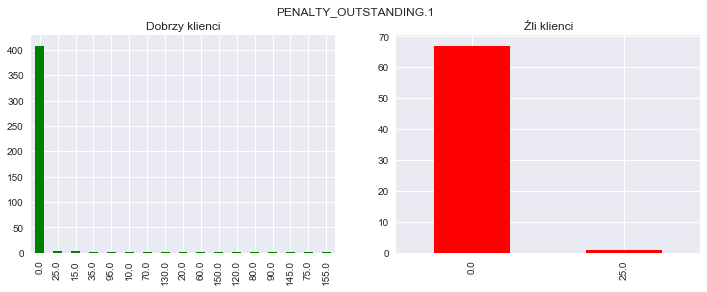

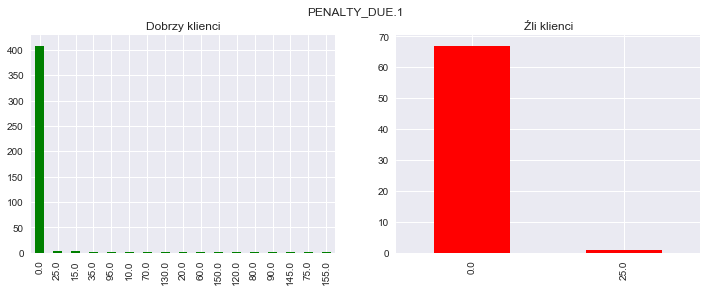

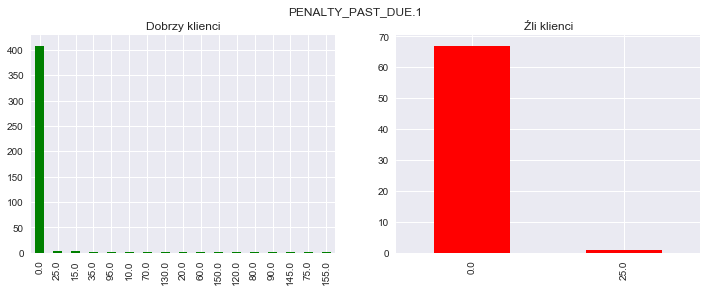

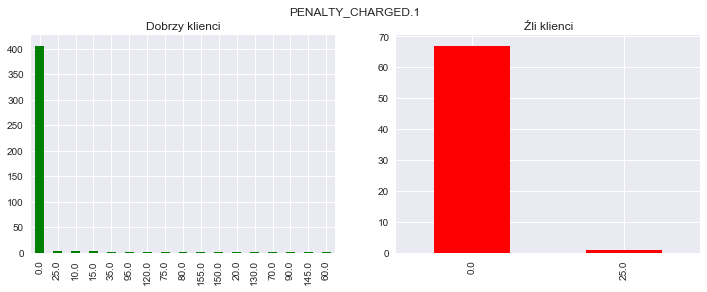

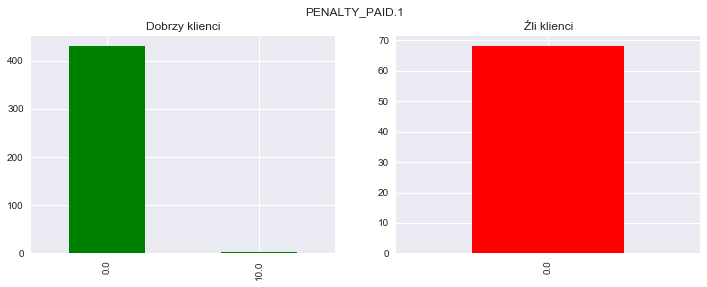

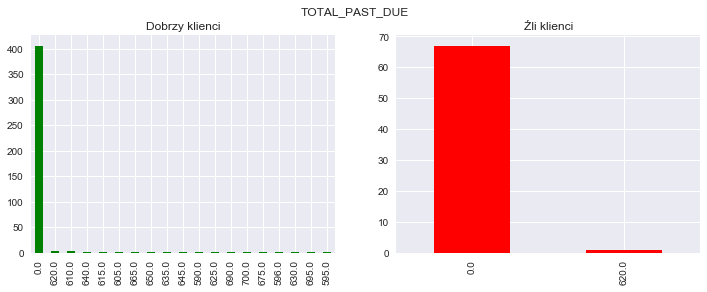

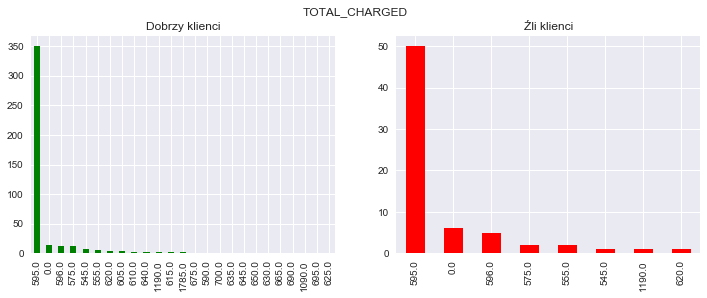

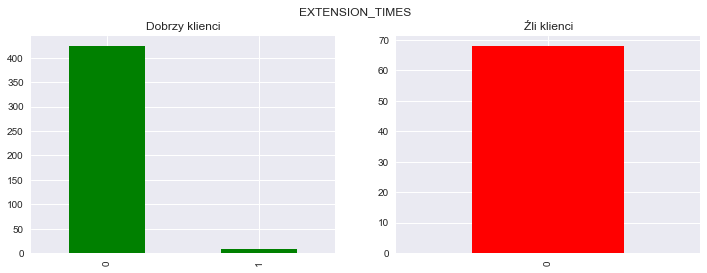

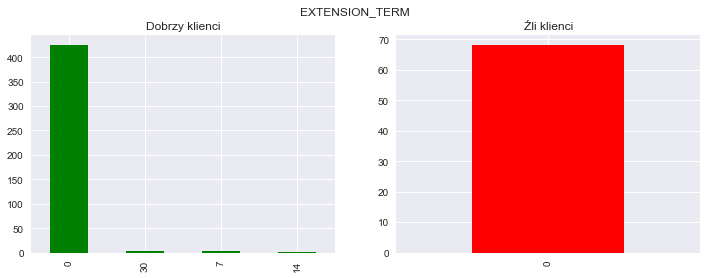

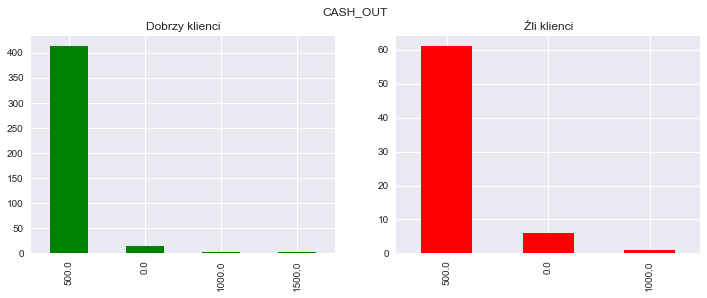

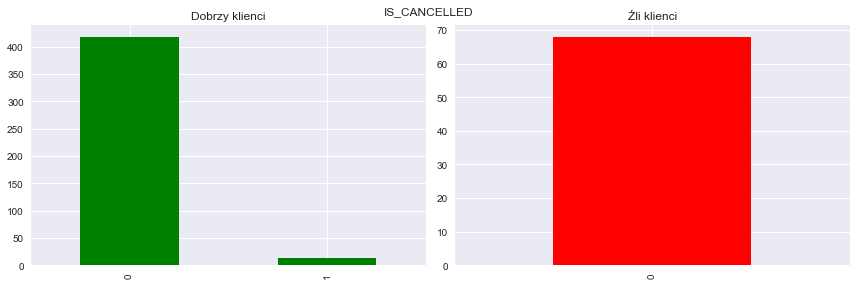

In [30]:
cols = df.drop(columns=['dpd', 'class'] + to_exclude).columns
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for col in cols:
        if df[col].quantile(0.15) == df[col].quantile(0.85):
            plt.figure(figsize=(12, 4))
            plt.suptitle(col.upper())
            for i in [0, 1]:
                plt.subplot2grid((1, 2), (0, i))
                plt.title(["Dobrzy klienci", "Źli klienci"][i])
                df[col][df['class'] == i].value_counts().plot.bar(color=['g', 'r'][i])
plt.tight_layout()
plt.show()

Dla wielu z tych zmiennych - w szczególności tych powiązanych z kapitałem (*principal*) - rozkład jest zdominowany przez jedną wartość, w identycznym niemal stopniu względem zmiennej decyzyjnej. To sprawia, że zmienne te będą bezużyteczne w procesie modelowania, trudno będzie je też pogrupować w analizie WoE. Wybrane poniżej przeznaczymy więc do wykluczenia z modelowania:

In [31]:
cols = ['principal_approved', 'requested_principal', 'principal_outstanding', 
     'principal_past_due', 'principal_paid.1', 'penalty_paid.1', 'extension_times']

In [32]:
for col in cols: to_exclude.append(col)

Przeanalizujemy teraz macierz korelacji Pearsona dla wszystkich pozostałych zmiennych:

In [33]:
def corr_plot(df, method='pearson'):
    corr = df.corr(method=method)
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, annot=True, cmap='seismic')
    plt.show()

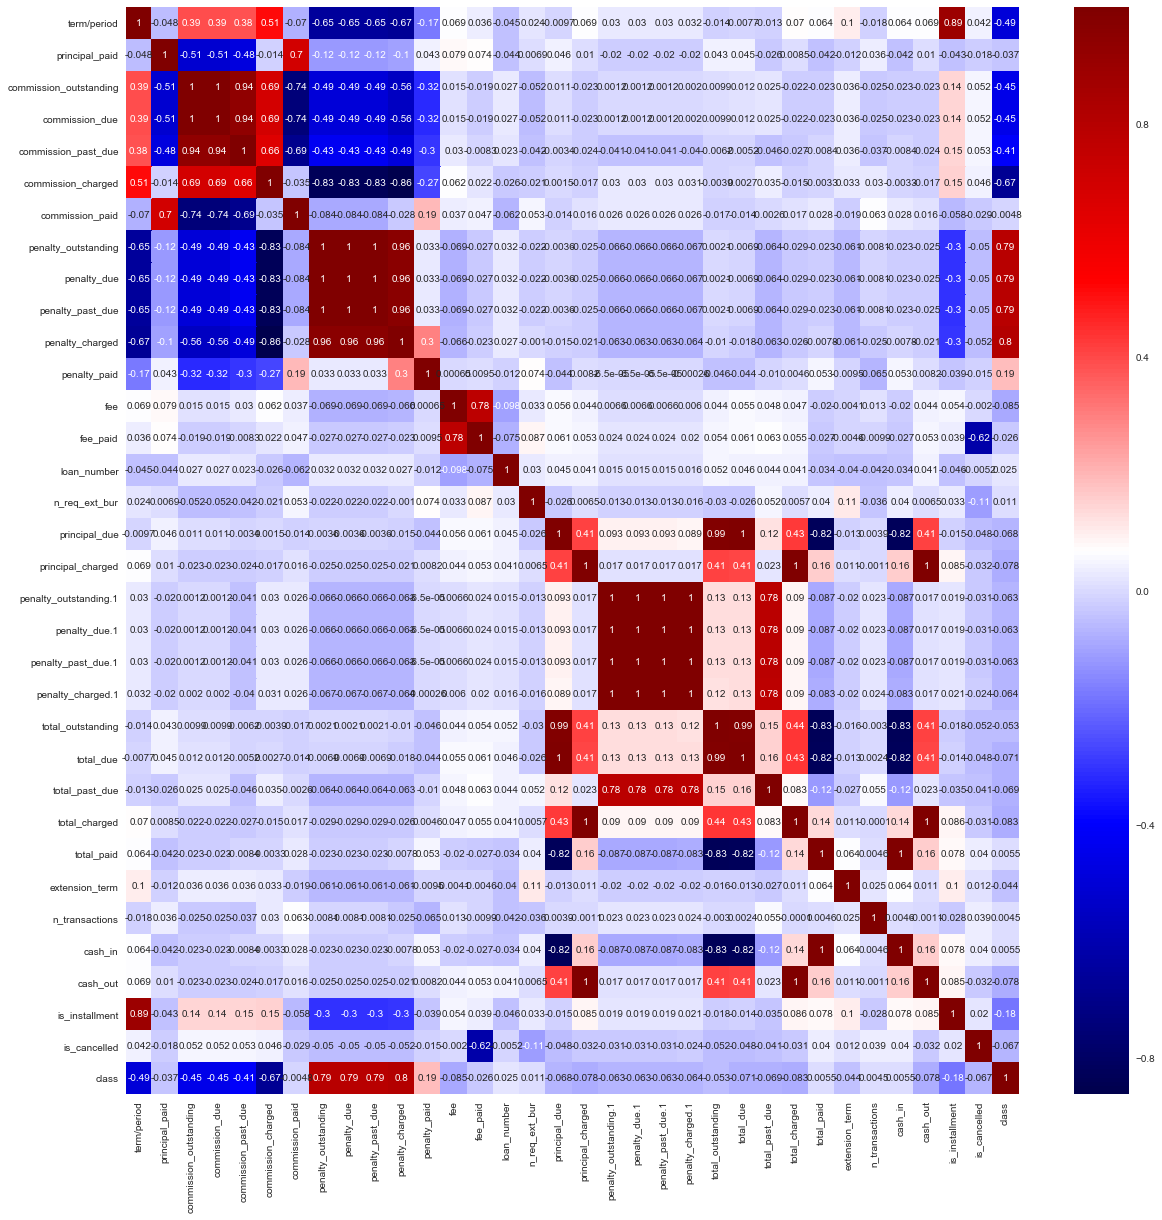

In [34]:
mdf = df.drop(columns=to_exclude)
corr_plot(mdf)

Pierwszym co rzuca się w oczy to fakt, że mamy do czynienia z całym szeregiem idealnie kolinearnych zmiennych (korelacja na poziomie 1). Z punktu widzenia informacji wnoszonych do modelu są to cechy zduplikowane, dla których ciężko lub niemożliwe będzie wiarygodne oszacowanie parametrów. 

W związku z tym z każdej takiej grupy powiązanych zmiennych wybierzemy jedną do dalszej analizy. Graniczną wartość korelacji ustawimy na poziomie większe / równe 0.99:

In [35]:
corr = mdf.corr()
unique_combinations = set([" ".join(sorted([col1, col2])) for col1 in corr.columns for col2 in corr.index if col1 != col2])
collinear_pairs = [[col1, col2] for col1, col2 in [c.split() for c in unique_combinations] if corr.loc[col1, col2] >= 0.99]
collinear_pairs

[['penalty_due.1', 'penalty_outstanding.1'],
 ['principal_charged', 'total_charged'],
 ['penalty_due', 'penalty_past_due'],
 ['cash_in', 'total_paid'],
 ['penalty_charged.1', 'penalty_past_due.1'],
 ['penalty_charged.1', 'penalty_outstanding.1'],
 ['penalty_outstanding', 'penalty_past_due'],
 ['commission_due', 'commission_outstanding'],
 ['cash_out', 'principal_charged'],
 ['principal_due', 'total_due'],
 ['penalty_due.1', 'penalty_past_due.1'],
 ['penalty_due', 'penalty_outstanding'],
 ['penalty_charged.1', 'penalty_due.1'],
 ['cash_out', 'total_charged'],
 ['penalty_outstanding.1', 'penalty_past_due.1']]

Te pary zmiennych spełniają założony warunek. Wybierzemy więc z nich zmienne do odrzucenia: 

In [36]:
dups = list(set([x[1] for x in collinear_pairs])); dups

['penalty_outstanding.1',
 'penalty_past_due.1',
 'principal_charged',
 'penalty_outstanding',
 'total_paid',
 'penalty_due.1',
 'total_charged',
 'penalty_past_due',
 'commission_outstanding',
 'total_due']

In [37]:
for col in dups: to_exclude.append(col)

Spójrzmy na korelogram Pearsona po odsianiu powyższych:

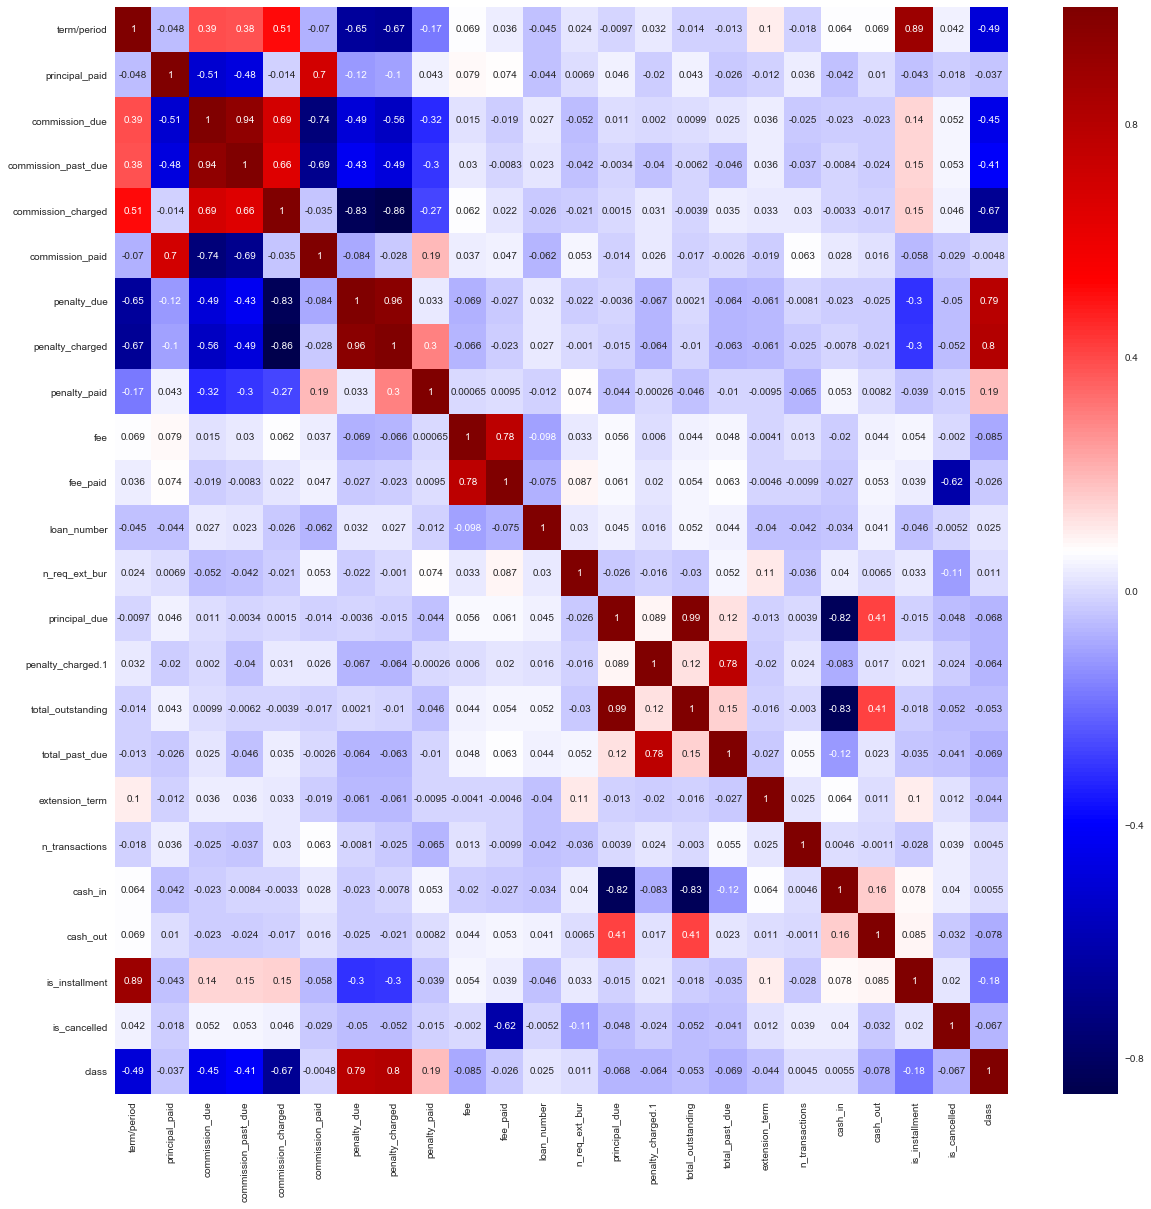

In [38]:
mdf = df.drop(columns=to_exclude)
corr_plot(mdf)

Wciąż widzimy grupy silnie powiązanych ze sobą zmiennych. To będzie coś co będziemy mieli na uwadze przy doborze poczególnych zmiennych do modelu aby zredukować maksymalnie kolinearność.

Widzimy też, że niektóre zmienne są relatywnie mocno powiązane z naszą zmienną decyzyjną:

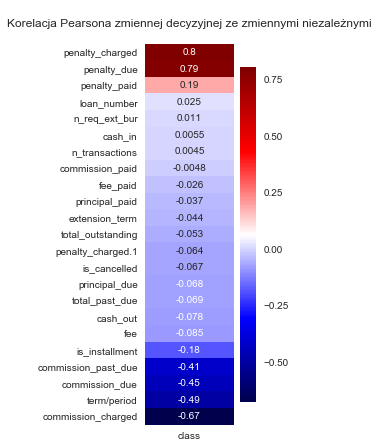

In [39]:
corr = mdf.corr()

plt.figure(figsize=(2,7))
plt.title('\nKorelacja Pearsona zmiennej decyzyjnej ze zmiennymi niezależnymi\n')
sns.heatmap(corr['class'].to_frame()[:-1].sort_values(by='class', ascending=False), cmap='seismic', annot=True)
plt.show()

przyjrzymy się dokładniej zmiennym, które mają najwyższe (>=0.18) bezwzględne wartości korelacji:

In [40]:
cols = corr['class'][abs(corr['class']) >= 0.18][:-1].index

In [41]:
def scat_plot(x, y, color='b'):
    plt.scatter(df[x], df[y], color=color)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'\n{x} vs {y}\n')

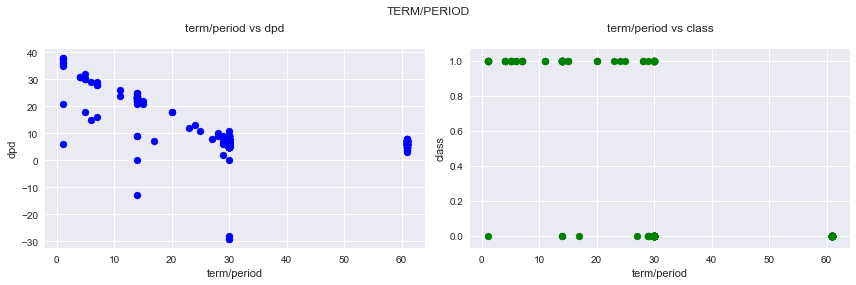

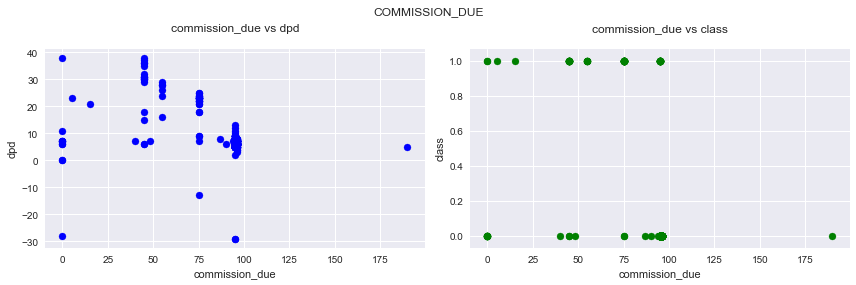

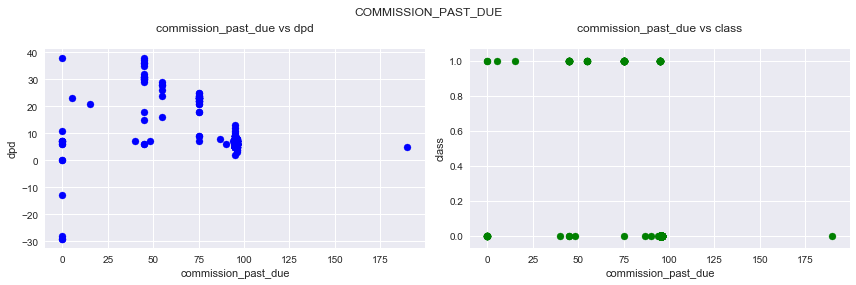

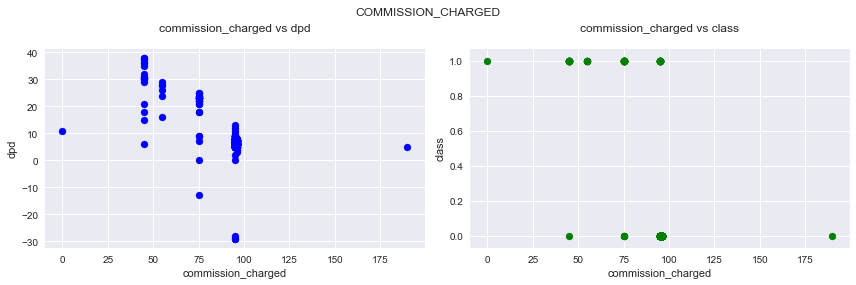

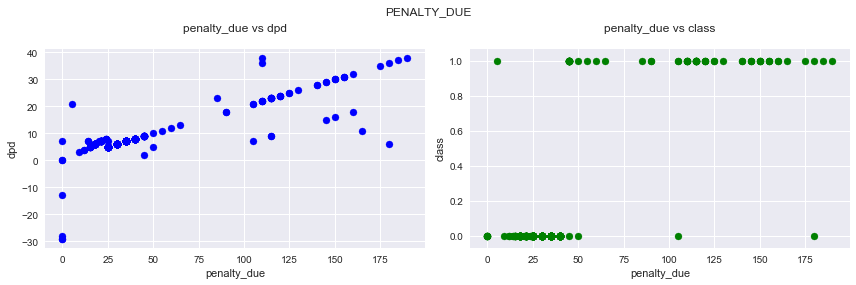

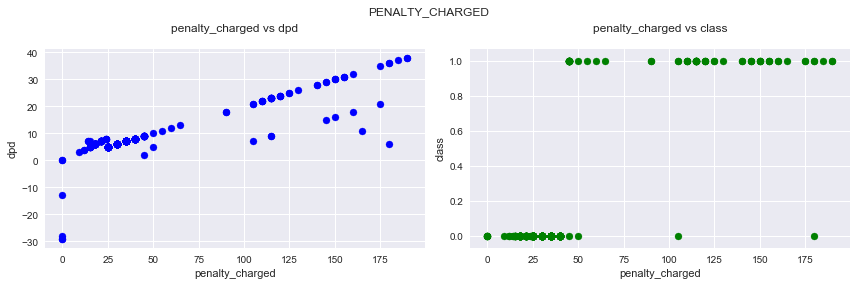

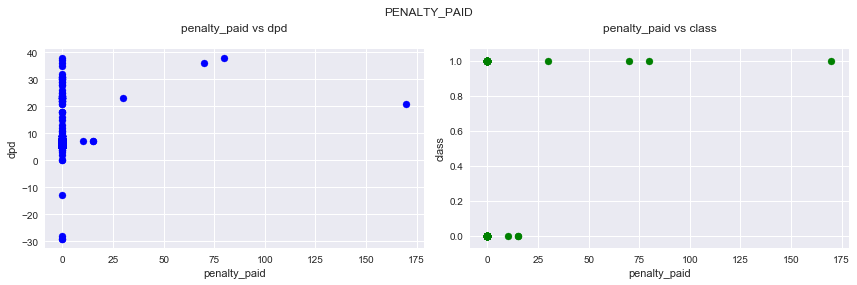

In [42]:
for col in cols: 
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{col.upper()}\n\n')
    for i in [0, 1]:
        var = ['dpd', 'class'][i]
        plt.subplot2grid((1, 2), (0, i))
        plt.title(f'\n{col} vs {var}')
        scat_plot(col, var, color=['b', 'g'][i])
        plt.tight_layout()
plt.show()

W przypadku `penalty_charged` i `penalty_due` widać praktycznie liniową zależność z `dpd`, która przekłada się potem na silną korelację ze zmienną decyzyjną. Być może wynika to z faktu, że identyczna kara naliczana jest za każdy dzień zwłoki.

Z kolei zmienna `penalty_paid` wydaje się zupełnie nie być skorelowana z `dpd` - relatywnie wysoka wartość korelacji to najpewniej wpływ wartości odstających.

## Kategoryzacja zmiennych - WoE i IV

Policzymy teraz wskaźniki *Weight of Evidence* (WoE) oraz *Information Value* (IV) dla cech w naszym zestawie danych aby wyselekcjonować te o najlepszych właściwościach informacyjnych do modelowania regresją logistyczną. Zdefiniujemy funkcję, która podzieli nasze zmienne na grupy bazując na kwantylach zmiennych i dla każdej podgrupy wyliczy wskaźniki WoE i IV. W rezultacie zwrócona zostanie tabela zawierająca statystyki dla wszystkich podgrup oraz druga tabela podsumowująca wyniki IV dla poszczególnych zmiennych:

In [43]:
def woe_iv_tables(mdf):
    idf = None
    
    # główna pętla wyliczająca WoE i IV: 
    for col in mdf.drop(columns='class').columns:
        # tabela dla poszczególnych zmiennych:
        targ = 'class'
        indep = col
        max_q = 20

        d = mdf[[targ, indep]].copy()
        d['bin'] = pd.qcut(d[indep], max_q, duplicates='drop')
        if len(d['bin'].unique()) == 1:
            mode = d[indep].mode()[0]
            d['bin'] = d[indep].apply(lambda x: f'is {mode}' if x==mode else f'not {mode}')
        d1 = d.groupby('bin')

        d2 = pd.DataFrame()
        d2['MIN_VAL'] = d1.min()[indep]
        d2['MAX_VAL'] = d1.max()[indep]
        d2['COUNT'] = d1.count()[targ]
        d2['PCT'] = d2['COUNT'] / len(d)
        d2['BADS'] = d1.sum()[targ]
        d2['GOODS'] = d2['COUNT'] - d2['BADS']
        d2['BADS_RATE'] = d2['BADS'] / d2['COUNT']
        d2['GOODS_RATE'] = 1 - d2['BADS_RATE']
        d2['DIST_BADS'] = d2['BADS'] / d2['BADS'].sum()
        d2['DIST_GOODS'] = d2['GOODS'] / d2['GOODS'].sum()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            d2['WOE'] = np.log(d2['DIST_GOODS'] / d2['DIST_BADS'])
        d2['IV'] = (d2['DIST_GOODS'] - d2['DIST_BADS'])*d2['WOE']
        d2 = d2.replace([np.inf, -np.inf], 0)

        d2['VAR_NAME'] = indep
        d2 = d2[[d2.columns[-1]] + list(d2.columns[:-1])]
        d2.reset_index(drop=True, inplace=True)
        
        # dopisywanie do tabeli głównej:
        if idf is None:
            idf = d2
        else:
            idf = idf.append(d2, ignore_index=True)
            
    # tabela maksymalnych wartości IV:
    iv = idf[['VAR_NAME', 'IV']].groupby('VAR_NAME').max().reset_index().sort_values(by='IV', ascending=False)
    
    return idf, iv

Przejrzyjmy teraz wyniki dla naszych danych:

In [44]:
idf, iv = woe_iv_tables(mdf)

In [45]:
idf.head()

,VAR_NAME,MIN_VAL,MAX_VAL,COUNT,PCT,BADS,GOODS,BADS_RATE,GOODS_RATE,DIST_BADS,DIST_GOODS,WOE,IV
0,term/period,1.0,14.0,46,0.092,43,3,0.934783,0.065217,0.632353,0.006944,-4.511506,2.821534
1,term/period,15.0,20.0,5,0.010,4,1,0.800000,0.200000,0.058824,0.002315,-3.235212,0.182818
2,term/period,23.0,30.0,364,0.728,21,343,0.057692,0.942308,0.308824,0.793981,0.944290,0.458130
3,term/period,61.0,61.0,85,0.170,0,85,0.000000,1.000000,0.000000,0.196759,0.000000,0.000000
4,principal_paid,0.0,0.0,489,0.978,67,422,0.137014,0.862986,0.985294,0.976852,-0.008605,0.000073


Podsumowanie IV:

In [46]:
iv

,VAR_NAME,IV
20,term/period,2.821534
16,penalty_due,1.940860
5,commission_past_due,1.908015
14,penalty_charged,1.851428
2,commission_charged,1.762589
3,commission_due,1.727441
13,n_transactions,0.180867
17,penalty_paid,0.110845
12,n_req_ext_bur,0.074326
22,total_past_due,0.054295


Wykorzystamy teraz pozyskane wkaźniki IV aby dobrać zmienne do modelu. Będziemy się tu kierować zasadą [*"one-in-ten"*](https://en.wikipedia.org/wiki/One_in_ten_rule), z pomocą której oszacujemy ile zmiennych powinniśmy maksymalnie uwzględnić w modelu:

In [47]:
n_vars = round(len(mdf[mdf['class'] == 1]) / 10); n_vars

7

Sporządzimy listę potencjalnych zmiennych do modelu na podstawie tabeli sumarycznej IV. Zmienne, które będziemy chcieli wykorzystać w modelu powinny przyjmować wartości IV z przedziału 0.02 do 0.5 - przymuje się, że wartości poniżej tego przedziału są bezwartościowe informacyjnie, zaś powyżej są *too good to be true*:

In [48]:
potential_vars = iv[(iv['IV'] >= 0.02) & (iv['IV'] <= 0.5)]; potential_vars

,VAR_NAME,IV
13,n_transactions,0.180867
17,penalty_paid,0.110845
12,n_req_ext_bur,0.074326
22,total_past_due,0.054295
21,total_outstanding,0.054295
15,penalty_charged.1,0.044990
10,is_installment,0.043110
7,fee,0.035142
18,principal_due,0.034902
11,loan_number,0.033691


Do modelowania wybierzemy zmienne o najwyższym wskaźniku IV:

In [49]:
model_vars = list(potential_vars['VAR_NAME'].values[:n_vars]); model_vars

['n_transactions',
 'penalty_paid',
 'n_req_ext_bur',
 'total_past_due',
 'total_outstanding',
 'penalty_charged.1',
 'is_installment']

Zgodnie z częstą w modelowaniu ryzyka kredytowania praktyką, dokonamy przekształcenia WoE naszych danych wejściowych, tj. zamienimy oryginalne wartości zmiennych na ich wskaźniki WoE z odpowiedniego przedziału. Zdefiniujemy funkcję mapującą:

In [50]:
def woe_transformation(model_vars):
    mdf_woe = mdf[model_vars].copy()
    for col in model_vars:
        col_idf = idf[idf['VAR_NAME'] == col]
        mdf_woe[col] = mdf_woe[col].apply(lambda x: col_idf[(col_idf['MIN_VAL'] <= x) 
                                                               & (col_idf['MAX_VAL'] >= x)]['WOE'].values[0])
    return mdf_woe

Następnie dokonamy transformacji:

In [51]:
mdf_woe = woe_transformation(model_vars); mdf_woe.head()

,n_transactions,penalty_paid,n_req_ext_bur,total_past_due,total_outstanding,penalty_charged.1,is_installment
loan_id,,,,,,,
1,1.585069,0.053656,1.121497,-0.042343,0.083293,-0.037453,-0.219101
2,-0.268468,0.053656,-0.332570,-0.042343,0.083293,-0.037453,-0.219101
3,1.585069,0.053656,-0.567984,1.329136,1.329136,1.242125,-0.219101
4,-0.393631,0.053656,-0.332570,-0.042343,-0.202092,-0.037453,0.000000
5,-0.221461,0.053656,-0.036539,-0.042343,0.083293,-0.037453,-0.219101


Zanim przejdziemy do modelowania, spojrzymy jeszcze raz na korelogram aby upewnić się, że unikamy zjawiska kolinearności:

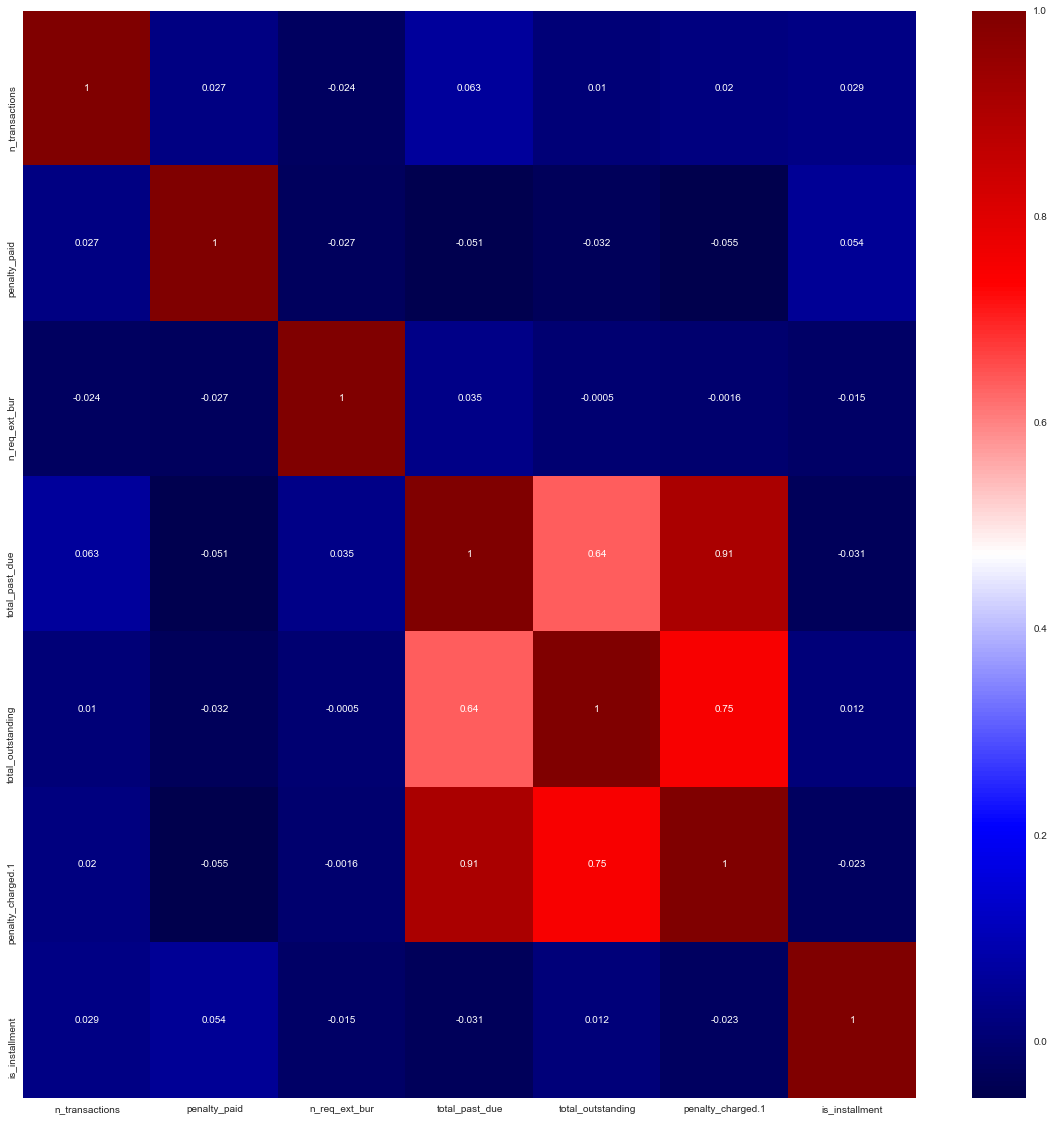

In [52]:
corr_plot(mdf_woe)

Zmienna `penalty_charged.1` jest silnie skorelowana z `total_past_due` i znacząco z `total_outstanding`. Zastąpimy ją zatem kolejną na liście IV zmienną - `fee`:

In [53]:
model_vars.pop(model_vars.index('penalty_charged.1'))
model_vars.append('fee')
model_vars

['n_transactions',
 'penalty_paid',
 'n_req_ext_bur',
 'total_past_due',
 'total_outstanding',
 'is_installment',
 'fee']

Jeszcze raz dokonamy transformacji WoE i spojrzymy na korelogram:

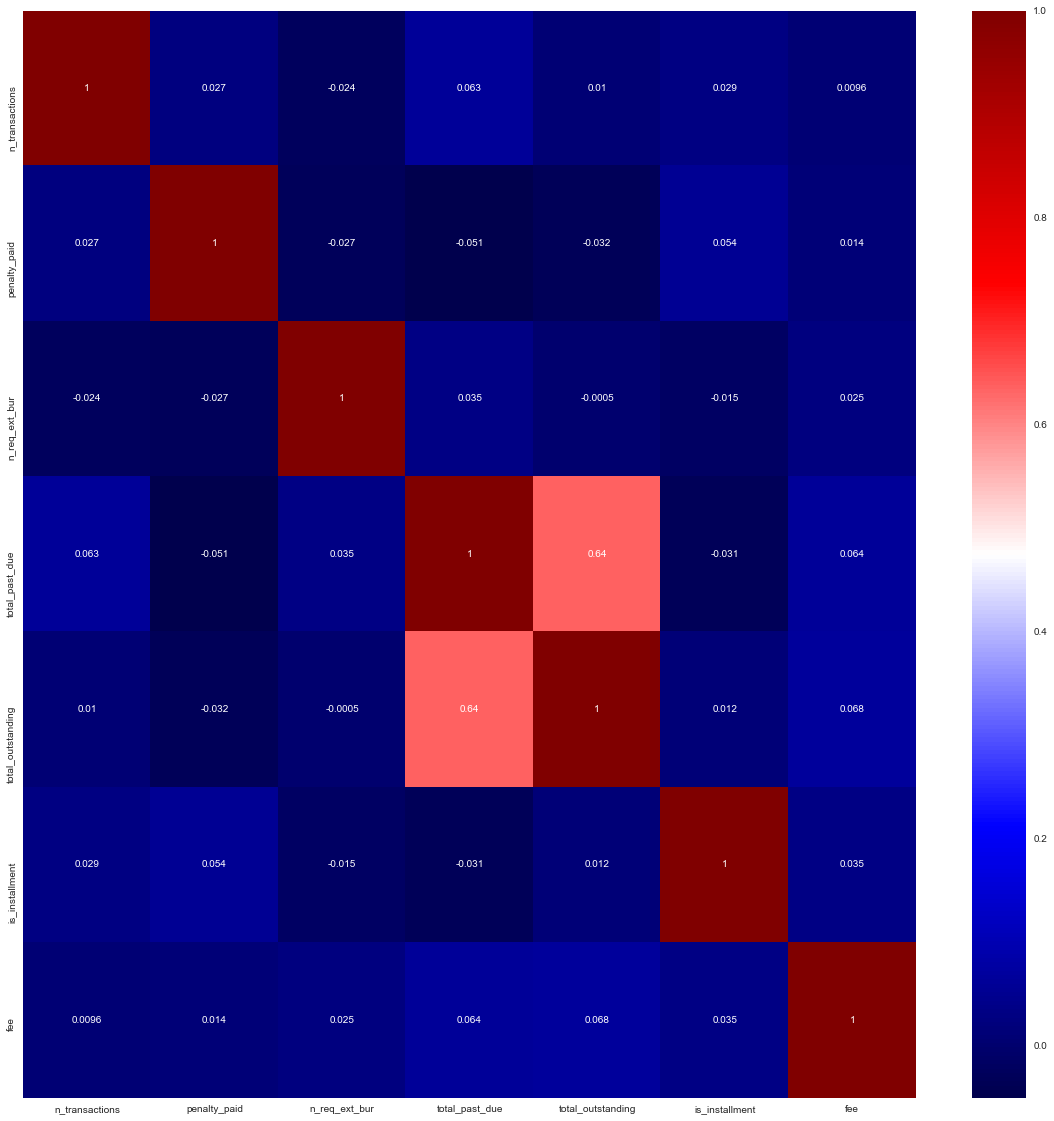

In [54]:
mdf_woe = woe_transformation(model_vars)
corr_plot(mdf_woe)

Teraz możemy wreszcie przejść do samego modelowania.

## Modelowanie

**Przygotowanie danych do modelowania**

Podzielimy nasze dane losowo na zestaw treningowy, który wykorzystamy do oszacowania parametrów regresji logistycznej, oraz testowy, na którym sprawdzimy skuteczność modelu przy pomocy zestawu metryk, który zdefiniujemy poniżej. Zgodnie z założeniami zadania, rozmiar zestawu testowego określimy jako 30% obserwacji:

In [55]:
def prepare_data(model_vars):
    X = mdf_woe[model_vars].values
    y = mdf['class'].values
    return train_test_split(X, y, test_size=0.3)

In [56]:
X_train, X_test, y_train, y_test = prepare_data(model_vars)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350, 7), (150, 7), (350,), (150,))

Teraz zdefiniujemy kluczowe metryki do oceny jakości modelu.

Po pierwsze będzie to statystyka Gini, którą można wyliczyć bezpośrednio z metryki [AUROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve):

In [57]:
def gini_stat(actuals, predictions):
    return 2 * metrics.roc_auc_score(actuals, predictions) - 1

Zdefiniujemy również powiązaną statystykę Kołomogorowa-Smirnowa, którą przeglądać będziemy razem z grafem obrazującym rezultaty:

In [58]:
def ks_stat(actuals, predictions, plot=True):
    # kalkulacja wskaźnika
    fpr, tpr, threshold = metrics.roc_curve(actuals, predictions)
    ks_df = pd.DataFrame(np.array(list(zip(tpr, fpr))))
    ks_df.columns = ['TPR', 'FPR']
    ks_df['K-S'] = ks_df['TPR'] - ks_df['FPR']
    KS = ks_df['K-S'].max()
    KS_ind, ymax, ymin = ks_df[ks_df['K-S'] == KS].reset_index().values[0][:3]
    
    # graf rezultatów
    if plot:
        plt.figure(figsize=(8,5))
        plt.title('')
        ks_df['TPR'].plot()
        ks_df['FPR'].plot()
        plt.axvline(x=KS_ind, ymax=ymax, ymin=ymin, linestyle=':', color='y', linewidth=3, label=f'KS = {KS:.2f}')
        plt.legend(loc='best')
        plt.show()
    return ks_df['K-S'].max()

Ponadto spojrzymy na macierz błędów:

In [62]:
def conf_mat(targ, preds):
    cm = metrics.confusion_matrix(targ, preds)
    cmp = pd.DataFrame(cm)
    cmp.index.name = 'Actuals'
    cmp.columns.name = 'Preds'

    plt.figure(figsize=(5, 5))
    plt.title("CONFUSION MATRIX")
    sns.set()
    sns.set(font_scale=1.25)
    sns.heatmap(cmp, annot=True, cmap="seismic", fmt='.0f')

    plt.tight_layout()

oraz na graf ROC:

In [63]:
def roc_plot(actuals, preds):
    fpr, tpr, threshold = metrics.roc_curve(actuals, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.2f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

**Estymacja modelu**

Czas stworzyć prototyp modelu regresji logistycznej. Posłużymy się tu implementacją z biblioteki statsmodels. W bibliotece tej stała do modelu nie jest automatycznie dodawana, zdefiniujemy więc funkcję, która zrobi to za nas:

In [64]:
def add_constant(data):
    const = np.ones((len(data), 1))
    return np.concatenate((const, data), axis=1)

Oszacujemy teraz model na wybranych zmiennych:

In [65]:
[[i, var] for i, var in enumerate(model_vars, 1)]

[[1, 'n_transactions'],
 [2, 'penalty_paid'],
 [3, 'n_req_ext_bur'],
 [4, 'total_past_due'],
 [5, 'total_outstanding'],
 [6, 'is_installment'],
 [7, 'fee']]

In [66]:
model = sm.Logit(y_train, add_constant(X_train))
results = model.fit(method='lbfgs')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  350
Model:                          Logit   Df Residuals:                      342
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:                  0.1495
Time:                        00:41:36   Log-Likelihood:                -110.90
converged:                       True   LL-Null:                       -130.40
                                        LLR p-value:                 1.954e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.9185    139.776     -0.100      0.921    -287.875     260.038
x1            -0.7672      0.399     -1.925      0.054      -1.549       0.014
x2            -0.3946      0.574     -0.688      0.492      -1.519       0.730
x3            -0.7579      0.322     -2.353      0.019      -1.389      -0.127
x4            -0.0756      0.852     -0.089      0.929      -1.746       1.594
x5            -0.7059      0.576     -1.226      0.220      -1.835       0.423
x6           -55.7168    637.955     -0.087      0.930   -1306.086    1194.652
x7            -1.7651      0.688     -2.565      0.010      -3.114      -0.416
==============================================================================

Possibly complete quasi-separation: A fraction 0.18 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Z analizy p-values dla poszczególnych parametrów oszacowanego modelu widać, że nie wszystkie zmienne są istotne statystycznie. Zredukujemy więc model, wykluczając z zestawu zmienną o najwyższej wartości p czyli x6 - `is_installment`:

In [67]:
model_vars.pop(model_vars.index('is_installment'))
[[i, var] for i, var in enumerate(model_vars, 1)]

[[1, 'n_transactions'],
 [2, 'penalty_paid'],
 [3, 'n_req_ext_bur'],
 [4, 'total_past_due'],
 [5, 'total_outstanding'],
 [6, 'fee']]

In [68]:
X_train, X_test, y_train, y_test = prepare_data(model_vars)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350, 6), (150, 6), (350,), (150,))

In [69]:
model = sm.Logit(y_train, add_constant(X_train))
results = model.fit(method='lbfgs')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  350
Model:                          Logit   Df Residuals:                      343
Method:                           MLE   Df Model:                            6
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:                  0.1339
Time:                        00:42:07   Log-Likelihood:                -125.87
converged:                       True   LL-Null:                       -145.32
                                        LLR p-value:                 7.469e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8400      0.177    -10.370      0.000      -2.188      -1.492
x1            -1.3973      0.504     -2.771      0.006      -2.386      -0.409
x2            -1.5275      0.467     -3.274      0.001      -2.442      -0.613
x3            -1.1023      0.332     -3.316      0.001      -1.754      -0.451
x4            -0.2653      0.986     -0.269      0.788      -2.198       1.668
x5            -0.6798      0.648     -1.049      0.294      -1.951       0.591
x6            -0.8089      0.635     -1.273      0.203      -2.054       0.437
==============================================================================
"""

Teraz najwyższe p-value ma x4 - `total_past_due`. Oszacujemy więc model bez tej zmiennej:

In [70]:
model_vars.pop(model_vars.index('total_past_due'))
[[i, var] for i, var in enumerate(model_vars, 1)]

[[1, 'n_transactions'],
 [2, 'penalty_paid'],
 [3, 'n_req_ext_bur'],
 [4, 'total_outstanding'],
 [5, 'fee']]

In [71]:
X_train, X_test, y_train, y_test = prepare_data(model_vars)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350, 5), (150, 5), (350,), (150,))

In [72]:
model = sm.Logit(y_train, add_constant(X_train))
results = model.fit(method='lbfgs')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  350
Model:                          Logit   Df Residuals:                      344
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:                  0.1223
Time:                        00:42:25   Log-Likelihood:                -124.40
converged:                       True   LL-Null:                       -141.74
                                        LLR p-value:                 1.748e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8585      0.174    -10.704      0.000      -2.199      -1.518
x1            -0.6807      0.380     -1.791      0.073      -1.426       0.064
x2            -1.4791      0.456     -3.244      0.001      -2.373      -0.585
x3            -1.0109      0.326     -3.102      0.002      -1.650      -0.372
x4            -0.9076      0.521     -1.742      0.081      -1.929       0.113
x5            -1.8127      0.682     -2.657      0.008      -3.150      -0.476
==============================================================================
"""

Nasz model skonstruowany jest teraz skonstruowany ze zmiennych istotnych przy poziomie istotności 0.1. Na tym etapie przejdziemy do dalszej ewaluacji.

Pierwszym krokiem będzie dokonanie predykcji dla zestawu testowego:

In [73]:
threshold = 0.5
probs = results.predict(add_constant(X_test))
preds = probs > threshold

W pierwszej kolejności spojrzymy na macierz błędów:

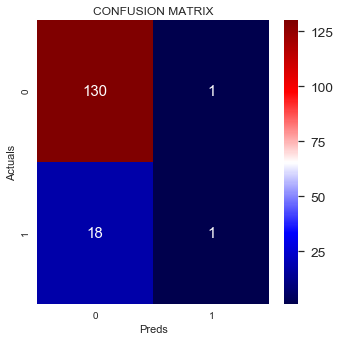

In [74]:
conf_mat(y_test, preds)

Przy wartości progowej klasyfikacji 0.5, model wykazuje się niedostateczną dyskryminacją: za wyjątkiem dwóch obserwacji wszystkie predykcje wskazują na dobrych klientów.

Widać to również w raporcie klasyfikacyjnym, gdzie wyniki uśrednione metodą macro (prosta średnia, bez ważenia ilością obserwacji per klasa zmiennej decyzyjnej) są stosunkowo niskie:

In [75]:
print('\t\t\tRaport klasyfikacyjny:\n'.upper())
print('\t', '='*45)
print(metrics.classification_report(y_test, preds))

			RAPORT KLASYFIKACYJNY:

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       131
           1       0.50      0.05      0.10        19

   micro avg       0.87      0.87      0.87       150
   macro avg       0.69      0.52      0.51       150
weighted avg       0.83      0.87      0.83       150



Spójrzmy teraz na wykres ROC, który pozwoli zrozumieć skuteczność naszego klasyfikatora przy różnych poziomach wartości progowej:

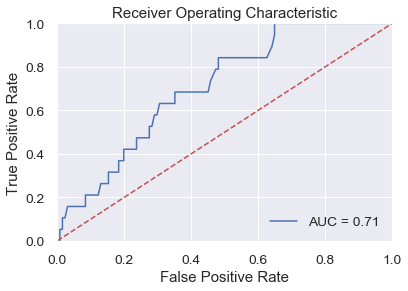

In [76]:
roc_plot(y_test, probs)

Wynik AUROC na poziomie 0.71 wskazuje na umiarkowane możliwości klasyfikatora w sprawnym dyskryminowaniu. Potwierdza to oczywiście statystyka Gini:

In [77]:
print(f'Statystyka Gini dla modelu: {gini_stat(y_test, probs):.4f}')

Statystyka Gini dla modelu: 0.4134


Spojrzymy też na statystykę KS, potwierdzającą po raz kolejny poprzednie wnioski co do możliwości modelu do skutecznej dyskryminacji:

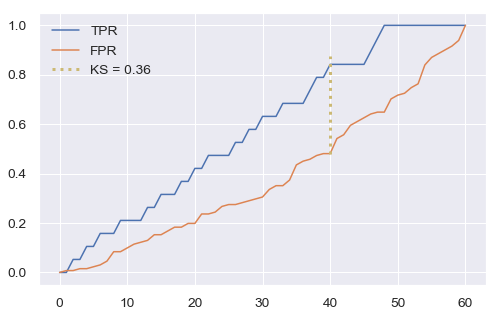

Statystyka KS dla modelu: 0.3612


In [78]:
print(f'Statystyka KS dla modelu: {ks_stat(y_test, probs):.4f}')

## Tworzenie karty scoringowej

Wynik dla karty scoringowej wyliczymy przy pomocy następującej formuły:

>**SCORE** = *OFFSET / N* - (*WOE_ib* x *Bi* + *A* / *N*) x *FACTOR*

gdzie:
* *N* - liczba zmiennych użytych w modelu
* *A* - stała estymowana w modelu
* *Bi* - współczynnik estymowany w modelu dla i-tej zmiennej
* *WOE_ib* - współczynnik WoE dla i-tej zmiennej i b-tego przedziału z analizy WoE


Jeśli chodzi o skalary *OFFSET* i *FACTOR*, wyliczymy je następująco:

> **FACTOR** = *PDO* / ln(2)

gdzie:
* *PDO* - ilość punktów potrzebna aby podwoić iloraz szans; ustalimy go jako 20 punktów

natomiast:
> **OFFSET** = *BASE SCORE* - (*FACTOR* x ln(*ODDS*))

gdzie:
* *ODDS* - bazowy iloraz szans; ustalimy go jako 50:1
* *BASE SCORE* - referencyjny wynik scorecard'u, dla którego mamy do czynienia z bazowym ilorazem szans; ustalimy go jako 600

Wedle powyższej definicji, skonstruujemy teraz scorecard:

In [83]:
scorecard = idf[idf['VAR_NAME'].isin(model_vars)].reset_index()

alpha = results.params[0]
B_vector = results.params[1:]
var_coeffs = {var: coeff for var, coeff in zip(model_vars, B_vector)}
n = len(model_vars)
eq_odds_score = 600
factor = 20 / np.log(2)
offset = eq_odds_score - factor * np.log(50)

scorecard['SCORECARD_POINTS'] = round(offset / n  - (scorecard['VAR_NAME'].apply(lambda var: var_coeffs[var]) * scorecard['WOE'] 
                                  + alpha / n) * factor).astype('int')
fin_result = ['VAR_NAME', 'MIN_VAL', 'MAX_VAL', 'SCORECARD_POINTS']
final_scorecard = scorecard[fin_result]
print('\t'*2,'SCORECARD')
display(final_scorecard)

		 SCORECARD


,VAR_NAME,MIN_VAL,MAX_VAL,SCORECARD_POINTS
0,penalty_paid,0.0,0.0,110
1,penalty_paid,10.0,170.0,17
2,fee,48.0,55.0,94
3,fee,74.0,75.0,99
4,fee,95.0,95.0,123
5,fee,110.0,110.0,108
6,n_req_ext_bur,1.0,2.0,117
7,n_req_ext_bur,3.0,3.0,88
8,n_req_ext_bur,4.0,4.0,97
9,n_req_ext_bur,5.0,5.0,120


Zweryfikujemy minimalną i maksymalną wartość punktową jaką można otrzymać na podstawie tak zdefiniowanego scorecard'u:

In [84]:
final_scorecard[['VAR_NAME', 'SCORECARD_POINTS']].groupby('VAR_NAME').agg(['min', 'max']).sum()

SCORECARD_POINTS  min    380
                  max    666
dtype: int64